# Skip-Gram word2vec with TF Text

The Skip-Gram model architecture tries to predict the context word given the current target word (the center word) which is the opposite to what CBOW does. The rest of this notebook demonstrates how to implement the Skip-Gram model with TensorFlow Text leveraging a publically available dataset. The steps are as follows

* Using TF Text to build a vocabulary
* Using TF Text to build a Skip-Gram data (target, context) generator
* Using TF Keras to build the Skip-Gram model architecture
* Using TF Keras to train the Skip-Gram model and get Word Embeddings
* Using Sklearn euclidean distances to calculate distance among words and get the k-nearst ones

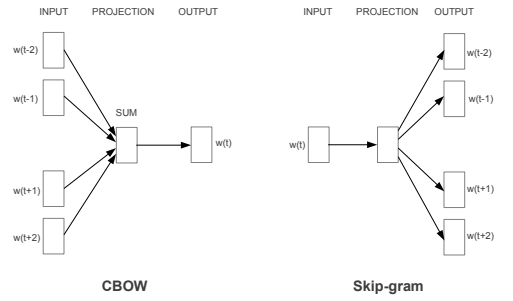

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
%%capture
%%bash
pip install -q tensorflow_text
pip install -q comet_ml

In [0]:
from comet_ml import Experiment

import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_text as tftext

from collections import Counter

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Dot, Reshape
from tensorflow.keras.utils import plot_model

import nltk
from nltk.corpus import stopwords
from nltk.corpus import gutenberg
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [0]:
COMET_API_KEY = 'N9ue7hxUF8fHmAunfA0EEaYbg'

In [6]:
%%capture
experiment = Experiment(
  api_key=COMET_API_KEY,
  project_name="tf-text-skipgram", workspace="dzlab",
  auto_param_logging=True, auto_metric_logging=True
)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/dzlab/tf-text-skipgram/1e62038ebb1a4263bd3e5689932f79c2



In [0]:
class config: pass
config.bs = 64
config.window = 2
config.shuffle_buffer_size = 1000
config.seed = 31
config.embed_size = 100

In [0]:
experiment.log_parameters(vars(config))

In [0]:
np.random.seed(config.seed)

## Data

In [0]:
%%capture
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')
nltk.corpus.gutenberg.fileids()

In [0]:
corpus = gutenberg.sents('bible-kjv.txt')

In [0]:
norm_corpus = list(map(lambda s: ' '.join(s), corpus))
norm_corpus = [' \n '.join(norm_corpus)]
norm_corpus = [re.sub("\d+|:|\[|\]", "", sentence) for sentence in norm_corpus]
# remove punctuation
cleaner = str.maketrans(string.punctuation, ' '*len(string.punctuation))
norm_corpus = [sentence.translate(cleaner) for sentence in norm_corpus]

Calculate score for subsampling frequent words

In [0]:
words = ''.join(norm_corpus).lower().split()
counts = Counter(words)
words_total = len(words)
threshold = 1.0 / (words_total + 1)

In [0]:
word2score = {}
for word,count in counts.items():
    freq = count / words_total
    word2score[word] = 1 - np.sqrt(threshold / freq)

(array([3951.,    0., 1739.,    0.,  971., 1530., 1020., 1358., 1239.,
         760.]),
 array([6.31438502e-07, 9.96053548e-02, 1.99210078e-01, 2.98814802e-01,
        3.98419525e-01, 4.98024248e-01, 5.97628972e-01, 6.97233695e-01,
        7.96838419e-01, 8.96443142e-01, 9.96047866e-01]),
 <a list of 10 Patch objects>)

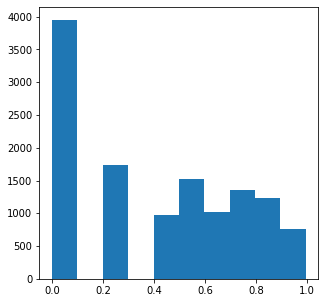

In [20]:
scores = list(word2score.values())
plt.figure(figsize=(5, 5))
plt.hist(scores)

Use the scoring function to remove stop words and subsample the rest

In [0]:
english_stopwords = set(stopwords.words('english'))

In [0]:
def subsample_stopwords(word):
  word = word.lower()
  if word in english_stopwords and word2score<np.random.rand():
    return False
  return True

def subsample(sentences):
  for sentence in sentences:
    words = filter(lambda w: w.lower() not in english_stopwords, sentence.split(' '))
    yield ' '.join(list(words)) + '.'

norm_corpus = list(subsample(norm_corpus))

## Text preprocessing

### Vocabulary creation
A first step of the text processing is to build a vocabulary out of the corpus. We will extract unique words and build a lookup table to map them into a unique numeric identifier.

In [0]:
def tokenize(text):
  # Lower case and normalize text
  text = tftext.case_fold_utf8(text)
  text = tftext.normalize_utf8(text, "NFD")
  # Tokenize and encode the text
  tokens_rt = tokenizer.tokenize(text)
  return tokens_rt

def create_vocab(text):
  # Create vocabulary from text
  rt = tokenize(text)
  tokens = rt.to_list()[0]
  return list(set(tokens))

def create_word2index(vocab, num_oov = 1):
  # Create a lookup table for a vocabulary
  vocab_values = tf.range(tf.size(vocab, out_type=tf.int64), dtype=tf.int64)
  init = tf.lookup.KeyValueTensorInitializer(keys=vocab, values=vocab_values, key_dtype=tf.string, value_dtype=tf.int64)
  return tf.lookup.StaticVocabularyTable(init, num_oov, lookup_key_dtype=tf.string)

def create_index2word(vocab):
  # Create a lookup table for a index to token
  vocab_values = tf.range(tf.size(vocab, out_type=tf.int64), dtype=tf.int64)
  init = tf.lookup.KeyValueTensorInitializer(keys=vocab_values, values=vocab)
  return tf.lookup.StaticHashTable(initializer=init, default_value=tf.constant('unk'), name="index2word")

In [24]:
tokenizer = tftext.UnicodeScriptTokenizer()
vocab = create_vocab([' '.join(norm_corpus)])
word2index = create_word2index(vocab)
index2word = create_index2word(vocab)

Instructions for updating:
`tf.batch_gather` is deprecated, please use `tf.gather` with `batch_dims=-1` instead.


In [0]:
vocab_size = len(vocab)

### Skip-Gram data generation

Generates skipgram word pairs from a sequence of words as follow:

* ((word, word in the same window), label), with label 1 (positive samples).
* ((word, random word from the vocabulary), label), with label 0 (negative samples).

In [0]:
#@tf.function
def basic_preprocess(text):
  # Tokenize text and create Skip-Gram features/labels
  tokens_rt = tokenize(text)
  # Create ngrams of size 2*window+1
  ngrams = tftext.ngrams(tokens_rt, width=(2*config.window+1), reduction_type=tftext.Reduction.STRING_JOIN, string_separator=' ')
  # make ngrams
  ngrams = tokenizer.tokenize(ngrams)
  ngrams = ngrams.to_tensor()
  ngrams = tf.squeeze(ngrams, axis=0)
  # take word from the right of the target word
  right = tf.concat([ngrams[:, config.window+(i+1)] for i in range(config.window)], axis=0)
  # take word from the left of the target word
  left = tf.concat([ngrams[:, config.window-(i+1)] for i in range(config.window)], axis=0)
  # combine words on right/left into the context
  context = tf.concat([left, right], axis=0)
  context_en = tf.ragged.map_flat_values(word2index.lookup, context)
  # make as much copies of target as there words in the context
  target = tf.concat([ngrams[:, config.window] for i in range(2*config.window)], axis=0)
  target_en = tf.ragged.map_flat_values(word2index.lookup, target)
  # positive labels are 1s
  positives_size = target.shape[0]
  positive_labels = tf.ones(positives_size)
  # negative samples are words not in the target window context
  negatives_size = target.shape[0]
  negtive_en = tf.random.uniform([negatives_size], minval=0, maxval=vocab_size-1, dtype=tf.dtypes.int64, seed=config.seed)
  # negative labels are 0s
  negative_labels = tf.zeros(negatives_size)
  # concat everything to create training data
  features = (tf.concat([target_en, target_en], axis=0), tf.concat([context_en, negtive_en], axis=0))
  labels = tf.concat([positive_labels, negative_labels], axis=0)
  return features, labels

In [0]:
text = ["PAD "*config.window + sentence + " PAD"*config.window for sentence in norm_corpus]
train_data = basic_preprocess(text)

In [28]:
train_data

((<tf.Tensor: shape=(2999568,), dtype=int64, numpy=array([ 9922,  8327,  6484, ..., 11771, 11883,   970])>,
  <tf.Tensor: shape=(2999568,), dtype=int64, numpy=array([12444,  9922,  8327, ...,  5263,  8621,  2604])>),
 <tf.Tensor: shape=(2999568,), dtype=float32, numpy=array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)>)

In [0]:
train_ds = tf.data.Dataset.from_tensor_slices(train_data)
train_ds = train_ds.shuffle(config.shuffle_buffer_size, seed=config.seed).batch(config.bs)

Let's have a look to one sample of the training data

In [30]:
dataframe = None
for X, y in train_ds.take(1):
  print(X[0].shape, X[1].shape, y.shape)
  word = index2word.lookup(X[0][:5]).numpy().tolist()
  context = index2word.lookup(X[1][:5]).numpy().tolist()
  target = y[:5].numpy()
  dataframe = pd.DataFrame(
      [[w, c, t] for w,c,t in zip(word, context, target)],
      columns=["word", "context", "label"]
    )
dataframe.head()

(64,) (64,) (64,)


,word,context,label
0,b'meat',b'herb',1.0
1,b'woman',b'done',1.0
2,b'flesh',b'bones',1.0
3,b'thou',b'shalt',1.0
4,b'dry',b'called',1.0


## Model

### Skip-Gram architecture

In [0]:
word_input = Input(shape=(1,))
context_input = Input(shape=(1,))

encoder = Embedding(vocab_size +1, config.embed_size,embeddings_initializer="glorot_uniform",input_length=1)
reshaper = Reshape((config.embed_size, ))

word = reshaper(encoder(word_input))

context = reshaper(encoder(context_input))

output = Dot(axes=-1)([word, context])
output = Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid")(output)

model = Model(inputs=[word_input, context_input], outputs=output)
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       1244500     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 100)          0           embedding[0][0]              

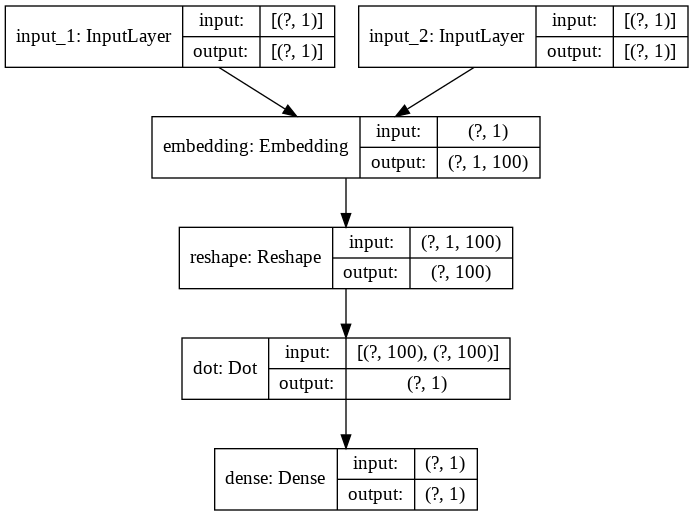

In [33]:
plot_model(model, to_file='tf-text-skipgram.png', show_shapes=True)

In [34]:
experiment.log_image('tf-text-skipgram.png')

{'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=2586994750044966ae953e21f20e1f0f&experimentKey=1e62038ebb1a4263bd3e5689932f79c2',
 'imageId': '2586994750044966ae953e21f20e1f0f',
 'web': 'https://www.comet.ml/api/image/download?imageId=2586994750044966ae953e21f20e1f0f&experimentKey=1e62038ebb1a4263bd3e5689932f79c2'}

In [35]:
model.fit(train_ds, epochs=10)

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE
COMET INFO: Ignoring automatic log_parameter('do_validation') because 'keras:do_validation' is in COMET_LOGGING_PARAMETERS_IGNORE


Train for 46869 steps
Epoch 1/10


COMET INFO: Ignoring automatic log_metric('batch_batch') because 'keras:batch_batch' is in COMET_LOGGING_METRICS_IGNORE
COMET INFO: Ignoring automatic log_metric('batch_size') because 'keras:batch_size' is in COMET_LOGGING_METRICS_IGNORE


46869/46869 [==============================] - 649s 14ms/step - loss: 0.0213 - accuracy: 0.9802
Epoch 2/10
46869/46869 [==============================] - 614s 13ms/step - loss: 0.0338 - accuracy: 0.9637
Epoch 3/10
46869/46869 [==============================] - 620s 13ms/step - loss: 0.0495 - accuracy: 0.9462
Epoch 4/10
46869/46869 [==============================] - 613s 13ms/step - loss: 0.0648 - accuracy: 0.9311
Epoch 5/10
46869/46869 [==============================] - 627s 13ms/step - loss: 0.0685 - accuracy: 0.9280
Epoch 6/10
46869/46869 [==============================] - 639s 14ms/step - loss: 0.0693 - accuracy: 0.9278
Epoch 7/10
46869/46869 [==============================] - 638s 14ms/step - loss: 0.0700 - accuracy: 0.9274
Epoch 8/10
46869/46869 [==============================] - 645s 14ms/step - loss: 0.0708 - accuracy: 0.9270
Epoch 9/10
46869/46869 [==============================] - 646s 14ms/step - loss: 0.0713 - accuracy: 0.9266
Epoch 10/10
46869/46869 [=======================

In [0]:
model.save('skip-gram.h5')

In [0]:
%%capture
experiment.log_model('skip-gram', 'skip-gram.h5', overwrite=True)

### Get the word2vec weights
Each word in the vocab has a dense embedding of size (1x100).

In [38]:
weights = model.get_weights()[0]
print(weights.shape)

(12445, 100)


### Contextual similarty
#### Compute pairwise distance matrix
We can levearage the embeddings that we just trained to find out some contextual similariry among words. For this, we need to do the following:

Build a pairwise distance matrix betweem all words in our vocabulary based on the embedding vectors.
Find the n-nearest neighbors of each word based on the shortest (euclidean) distance.

In [39]:
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

(12445, 12445)


### View contextually similar words
We can clearly see that some of the closest words to the initial words make sense contextually (egypt, canaan). This is a good sign as it we can get better embeddings if we train for more epochs.



In [0]:
target = ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']

indices = word2index.lookup(tf.constant(target))
top5_indices = distance_matrix[indices.numpy()].argsort()[:, 1:6]
top5 = index2word.lookup(tf.constant(top5_indices)).numpy().tolist()

In [41]:
pd.DataFrame(
  [[t]+c for c,t in zip(top5, target)],
  columns=["word", "top1", "top2", "top3", "top4", "top5"]
)

,word,top1,top2,top3,top4,top5
0,god,b'behold',b'hath',b'ye',b'lord',b'saw'
1,jesus,b'baptized',b'crushed',b'defence',b'rocks',b'toi'
2,noah,b'wives',b'daughters',b'generations',b'eight',b'forty'
3,egypt,b'journey',b'sarah',b'pillar',b'dinah',b'dreamed'
4,john,b'soldiers',b'buildeth',b'bundle',b'baptism',b'transgressors'
5,gospel,b'baptism',b'publicans',b'jaws',b'ravenous',b'adulterous'
6,moses,b'jethro',b'laban',b'wept',b'journey',b'overtook'
7,famine,b'stolen',b'alive',b'sinned',b'memorial',b'afflict'


Let's visualize this same data uising t-SNE

In [42]:
words = sum([[t]+c for c,t in zip(top5, target)], [])
ids = word2index.lookup(tf.constant(words)).numpy()
vectors = np.array([weights[idx] for idx in ids])
print('Total words:', len(words), '\tWord Embedding shapes:', vectors.shape)

Total words: 48 	Word Embedding shapes: (48, 100)


Project embeddings into 2dim with t-SNE

In [0]:
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(vectors)

Plot the t-SNE data

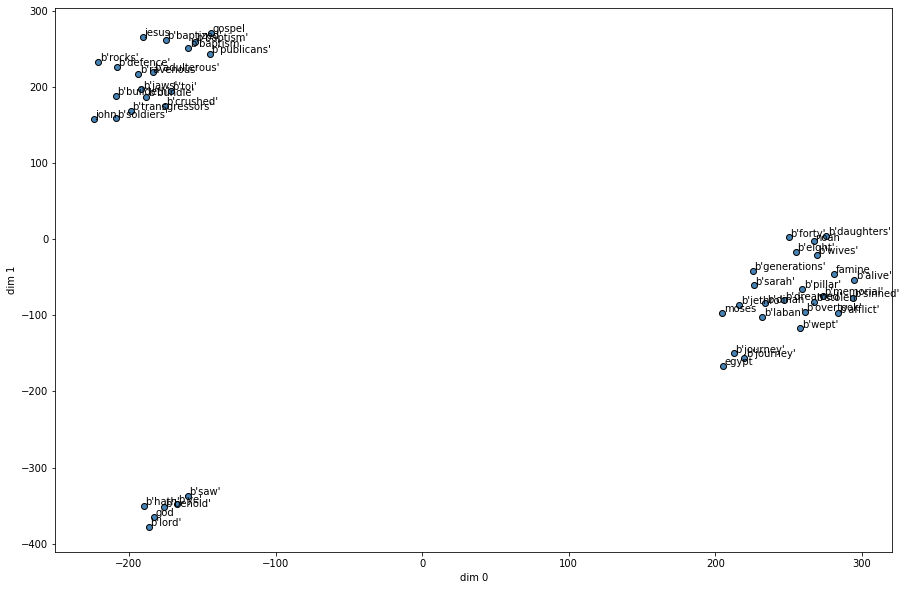

<Figure size 432x288 with 0 Axes>

In [44]:
plt.figure(figsize=(15, 10))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(words, T[:, 0], T[:, 1]):
  plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')
plt.xlabel('dim 0')
plt.ylabel('dim 1')
plt.show()
plt.savefig('tsne.png')

In [45]:
experiment.log_image('tsne.png', overwrite=True)

{'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=f0f5dc01dc0a4a22b7d3f4394aeffe08&experimentKey=1e62038ebb1a4263bd3e5689932f79c2',
 'imageId': 'f0f5dc01dc0a4a22b7d3f4394aeffe08',
 'web': 'https://www.comet.ml/api/image/download?imageId=f0f5dc01dc0a4a22b7d3f4394aeffe08&experimentKey=1e62038ebb1a4263bd3e5689932f79c2'}